In [1]:
from __future__ import print_function
import datetime
import time
from functools import reduce
import os

import pyarrow.parquet as parquet
import pandas as pd
import numpy as np
%matplotlib nbagg
import matplotlib.pyplot as plt
import copy

from fastset import FastSet

In [2]:
resultDirectory = 'Results/classads/UCSD/'
if not os.path.exists(resultDirectory):
    os.mkdir(resultDirectory)

In [3]:
startTime = datetime.datetime.now()

In [4]:
# Data collected from a spark query at CERN, in pandas pickle format
# CRAB jobs only have data after Oct. 2017
# ws = pd.read_pickle("data/working_set_day.pkl.gz")
# spark returns lists, we want to use sets
# ws['working_set_blocks'] = ws.apply(lambda x: set(x.working_set_blocks), 'columns')
# ws['working_set'] = ws.apply(lambda x: set(x.working_set), 'columns')

# Reading from working_set_day 
ws = parquet.read_table('data/working_set_day').to_pandas()
# spark returns lists, we want to use sets
ws['working_set_blocks'] = ws.apply(lambda x: FastSet(x.working_set_blocks), 'columns')

In [5]:
print(ws)

                  day SubmissionTool          input_campaign  d_data_tier_id  \
0        1.453162e+09          crab3                      HC             122   
1        1.453162e+09          crab3   RunIISpring15FSPremix           31224   
2        1.453248e+09          crab3                Run2015B               7   
3        1.453248e+09          crab3                Run2015D               9   
4        1.453334e+09          crab3                Run2015C               9   
5        1.453334e+09          crab3       RunIISpring15DR74              21   
6        1.453421e+09          crab2    RunIIFall15MiniAODv1           31224   
7        1.453421e+09          crab2       RunIISpring15DR74              21   
8        1.453421e+09          crab2  RunIISpring15MiniAODv2           31224   
9        1.453421e+09          crab3    RunIIFall15MiniAODv2           31224   
10       1.453507e+09          crab3                  HCtest             122   
11       1.453507e+09          crab3    

In [6]:
# Isolating the data associated with US sites
#US_ws = ws.loc[ws['SiteName'].str.startswith('T2_US')]
#print(US_ws)

In [7]:
#   DBS BLOCKS table schema:
#     BLOCK_ID NOT NULL NUMBER(38)
#     BLOCK_NAME NOT NULL VARCHAR2(500)
#     DATASET_ID NOT NULL NUMBER(38)
#     OPEN_FOR_WRITING NOT NULL NUMBER(38)
#     ORIGIN_SITE_NAME NOT NULL VARCHAR2(100)
#     BLOCK_SIZE NUMBER(38)
#     FILE_COUNT NUMBER(38)
#     CREATION_DATE NUMBER(38)
#     CREATE_BY VARCHAR2(500)
#     LAST_MODIFICATION_DATE NUMBER(38)
#     LAST_MODIFIED_BY VARCHAR2(500)
if not os.path.exists('data/block_size.npy'):
    blocksize = pd.read_csv("data/dbs_blocks.csv.gz", dtype='i8', usecols=(0,5), names=['block_id', 'block_size'])
    np.save('data/block_size.npy', blocksize.values)
    blocksize = blocksize.values
else:
    blocksize = np.load('data/block_size.npy')

# We'll be accessing randomly, make a dictionary
# blocksize = {v[0]:v[1] for v in blocksize}
# We'll be accessing randomly, make a fast lookup
bsort = np.argsort(blocksize[:,0])
bsize_index = blocksize[bsort, 0]
bsize_values = blocksize[bsort, 1]
def getsize(s):
    return bsize_values[np.searchsorted(bsize_index, s._set)].sum()
def getsetsize(s):
    return bsize_values[np.searchsorted(bsize_index, s)].sum()

In [8]:
# join the data tier definitions
datatiers = pd.read_csv('data/dbs_datatiers.csv').set_index('id')
ws['data_tier'] = datatiers.loc[ws.d_data_tier_id].data_tier.values

In [9]:
date_index = np.arange(np.min(ws.day.values//86400), np.max(ws.day.values//86400)+1)
date_index_ts = np.array(list(datetime.date.fromtimestamp(day*86400) for day in date_index))

In [10]:
tic = time.time()

is_crab = ws.SubmissionTool=='crab3'
is_miniaod = ws.data_tier.str.contains('MINIAOD')
is_us = ws.SiteName.str.match('T[23]_US')
is_ucsd = ws.SiteName.str.match('T[23]_US_UCSD')
ws_filtered = ws[is_crab & is_miniaod & is_ucsd]

blocks_day = []
for i, day in enumerate(date_index):
    today = (ws_filtered.day==day*86400)
    blocks_day.append(reduce(FastSet.union, ws_filtered[today].working_set_blocks, FastSet()))

print("Done assembling blocklists")

nrecords = np.zeros_like(date_index)
lifetimes = {
    '1w': 7,
    '1m': 30,
    '3m': 90,
    '6m': 120,
}
ws_size = {k: np.zeros_like(date_index) for k in lifetimes}
nrecalls = {k: np.zeros_like(date_index) for k in lifetimes}
recall_size = {k: np.zeros_like(date_index) for k in lifetimes}
previous = {k: FastSet() for k in lifetimes}

for i, day in enumerate(date_index):
    nrecords[i] = ws_filtered[(ws_filtered.day==day*86400)].size
    for key in lifetimes:
        current = reduce(FastSet.union, blocks_day[max(0,i-lifetimes[key]):i+1], FastSet())
        recall = current - previous[key]
        nrecalls[key][i] = len(recall)
        ws_size[key][i] = getsize(current)
        recall_size[key][i] = getsize(recall)
        previous[key] = current
    if i%30==0:
        print("Day ", i)

elapsed = time.time() - tic
print("Done in %.1f seconds" % elapsed)

Done assembling blocklists
Day  0
Day  30
Day  60
Day  90
Day  120
Day  150
Day  180
Day  210
Day  240
Day  270
Day  300
Day  330
Day  360
Day  390
Day  420
Day  450
Day  480
Day  510
Day  540
Day  570
Day  600
Day  630
Day  660
Day  690
Day  720
Day  750
Day  780
Day  810
Day  840
Day  870
Day  900
Day  930
Day  960
Day  990
Day  1020
Day  1050
Day  1080
Done in 34.5 seconds


In [11]:
# block_dict is a dictionary that holds the lists of blocks
# for all of the days for which the lists are nonzero
# Keys: Day
# Values: List of Blocks that were accessed on that Day
block_dict = {}
i=0
for el in blocks_day:
    i=i+1
    if len(el)>0:
        block_dict[i] = el

print("Merging daily block lists into one block set")
block_list = []
for i in range(len(blocks_day)):
    block_list += blocks_day[i]
# block_set is a set of all unique blocks.
# This can be used to isolate properties of individual blocks
# (e.g. how many times a block is accessed)
block_set = set(block_list)
print("Block Set Created")

Merging daily block lists into one block set
Block Set Created


In [40]:
# Rounds down the number to the multiple specified by the divisor
def round_down(num, divisor):
    return num - (num % divisor)

# Counts the frequencies of the quantities of blocks reused in an
# n day period (over all given time) where n = threshold
# Parameters: threshold - integer that determines the range of days (counted back from the given day)
#                         over which the blocks are counted
#             bucket - integer that determines "tolerance" for quantity of blocks such that
#                      the blocks are counted together (e.g. a bucket of 1000 means that a
#                      quantity of blocks less than 2000 would be counted as part of the
#                      1000 bucket because it is being rounded down)
def countBlockReuseFreq(threshold, bucket):
    block_reuse_dict = {}
    for day in block_dict:
        try:
            b = block_dict[day].set()
            i = day
            # t_block_set is the set of all blocks accesed in the n-day
            # period
            t_block_set = copy.deepcopy(b)
            # unique_set is the set of all blocks accessed only once
            # in the n-day period
            unique_set = block_dict[day].set()
            for i in range(day+1, day+threshold+1):
                t_block_set.update(block_dict[i])
                unique_set = unique_set.difference(block_dict[i])
            # b is the set of all blocks accessed more than once
            b = t_block_set.difference(unique_set)
            # Rounds down to the bin and checks to see if such a bin exists in the dictionary
            if round_down(len(b), bucket) in block_reuse_dict:
                block_reuse_dict[round_down(len(b), bucket)] += 1
            else:
                block_reuse_dict[round_down(len(b), bucket)] = 1
        except Exception as e:
            emptykey = e
            
    # Returns block_reuse_dict
    # Keys: Number of Blocks reused within the given threshold
    #       (organized by the given buckets)
    # Values: Frequencies of occurrence
    return block_reuse_dict

# Counts the frequencies of the total number of bytes reused in an
# n day period (over all given time) where n = threshold
# Parameters: threshold - integer that determines the range of days (counted back from the given day)
#                         over which the blocks are counted
#             bucket - integer that determines "tolerance" for bytes such that
#                      the bytes are counted together (e.g. a bucket of 1000 means that a
#                      size of less than 2000 bytes would be counted as part of the
#                      1000 byte bucket because it is being rounded down)
def countByteReuseFreq(threshold, bucket):
    byte_reuse_dict = {}
    for day in block_dict:
        try:
            b = block_dict[day].set()
             # t_block_set is the set of all blocks accesed in the n-day
            # period
            t_block_set = copy.deepcopy(b)
            # unique_set is the set of all blocks accessed only once
            # in the n-day period
            unique_set = block_dict[day].set()
            i = day
            for i in range(day+1, day+threshold+1):
                t_block_set.update(block_dict[i])
                unique_set = unique_set.difference(block_dict[i])
            # b is the set of all blocks accessed more than once
            b = t_block_set.difference(unique_set)
            # Counting the number of bytes in b
            bSize = getsize(FastSet(b))
            # Rounds down to the bin and checks to see if such a bin exists in the dictionary
            if round_down(bSize, bucket) in byte_reuse_dict:
                # Adding the number of bytes into the given block into the current bin
                byte_reuse_dict[round_down(bSize, bucket)] += 1
            else:
                byte_reuse_dict[round_down(bSize, bucket)] = 1
        except Exception as e:
            emptykey = e
    
    # Returns byte_reuse_dict
    # Keys: Bytes reused within the given threshold (organized by the given buckets)
    # Values: Frequencies of occurrence
    return byte_reuse_dict

# Counts the frequencies of the total number of bytes reused in an
# n day period (over all given time) where n = threshold
# Returns them as a fraction: (Reused Bytes for a given day) / (Bytes accessed for a given day) 
# Parameters: threshold - integer that determines the range of days (counted back from the given day)
#                         over which the blocks are counted
#             bucket - integer that determines "tolerance" for percentage of byte usage 
#                      such that the percentage of byte usage are counted together (e.g. 
#                      a bucket of 0.05 means that a size of less than 0.10 would be counted as
#                      part of the 0.05 percentage bucket because it is being rounded down)
def countByteFracReuseFreq(threshold, bucket):
    byte_reuse_dict = {}
    for day in block_dict:
        try:
            b = block_dict[day].set()
            # unique_set is the ste of all block accessed only once in the
            # n-day period
            unique_set = block_dict[day].set()
            # t_block_set is the set of all blocks accessed in the n-day
            # time period
            t_block_set = copy.deepcopy(b)
            i = day
            tSize = 0
            # Populating tSize with the bytes accessed in the given day
            tSize = getsize(block_dict[day])
            for i in range(day+1, day+threshold+1):
                t_block_set.update(block_dict[i])
                unique_set = unique_set.difference(block_dict[i])
                # Counting the number of bytes accessed in the days within the threshold
                tSize += getsize(block_dict[i])
            # b is the set of all blocks accessed more than once in the n-day
            # period
            b = t_block_set.difference(unique_set)
            # Counting the number of bytes in b
            bSize = 0
            bSize += getsize(FastSet(b))
            percent = float(bSize)/float(tSize)
            # Rounds down to the bin and checks to see if such a bin exists in the dictionary
            if round_down(percent, bucket) in byte_reuse_dict:
                # Adding the number of bytes into the given block into the current bin
                byte_reuse_dict[round_down(percent, bucket)] += 1
            else:
                byte_reuse_dict[round_down(percent, bucket)] = 1
        except Exception as e:
            emptykey = e
    
    # Returns byte_reuse_dict
    # Keys: Bytes reused within the given threshold (organized by the given buckets)
    # Values: Frequencies of occurrence
    return byte_reuse_dict

In [41]:
print([x / 1e15 for x in list(countByteReuseFreq(1, 8*1e13).keys())])
print([x / 1 for x in list(countByteReuseFreq(1, 8*1e13).values())])
print([x / 1e15 for x in list(countByteReuseFreq(14, 8*1e13).keys())])
print([x / 1 for x in list(countByteReuseFreq(14, 8*1e13).values())])

[0.0, 0.08, 0.32, 0.16, 0.24]
[482.0, 255.0, 6.0, 184.0, 59.0]
[0.0, 0.08, 0.32, 0.56, 0.88, 0.64, 0.4, 0.16, 0.96, 0.48, 0.24, 0.8, 0.72]
[9.0, 133.0, 70.0, 95.0, 30.0, 63.0, 37.0, 146.0, 14.0, 64.0, 157.0, 68.0, 61.0]


<IPython.core.display.Javascript object>


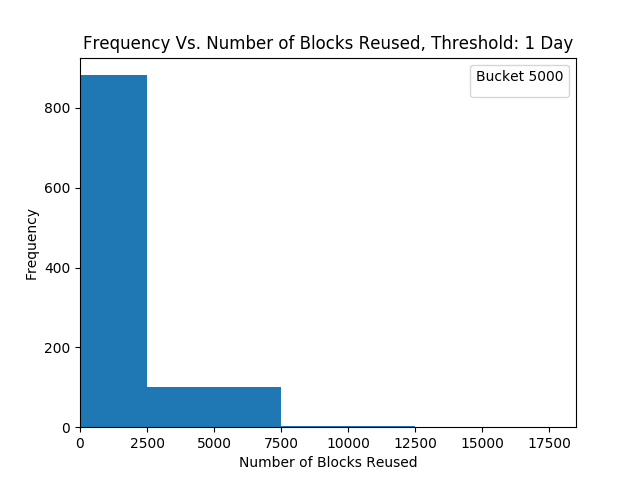

No handles with labels found to put in legend.


In [42]:
fig, ax = plt.subplots(1,1)
bucket = 5000
block_reuse_dict1 = countBlockReuseFreq(1, bucket)
ax.bar(list(block_reuse_dict1.keys()), list(block_reuse_dict1.values()), width=bucket)
ax.set_title('Frequency Vs. Number of Blocks Reused, Threshold: 1 Day')
ax.legend(title='Bucket ' + str(bucket))
ax.set_ylabel('Frequency')
ax.set_xlabel('Number of Blocks Reused')
ax.set_ylim(0, None)
ax.set_xlim(0, None)
plt.savefig(resultDirectory + 'BlockReuseThreshold1.png')

<IPython.core.display.Javascript object>


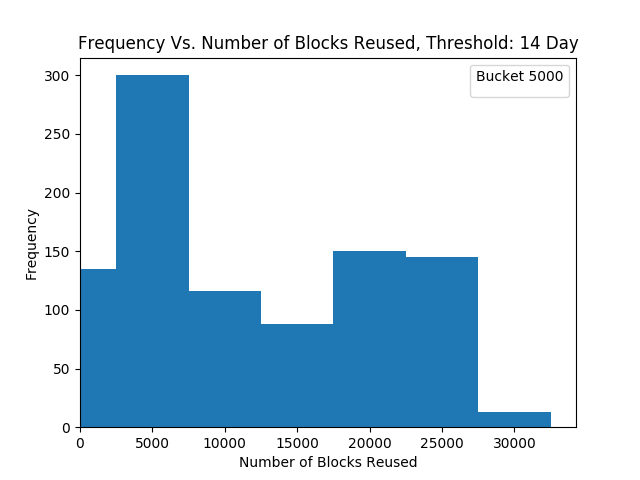

No handles with labels found to put in legend.


In [43]:
fig, ax = plt.subplots(1,1)
bucket = 5000
block_reuse_dict14 = countBlockReuseFreq(14, bucket)
ax.bar(list(block_reuse_dict14.keys()), list(block_reuse_dict14.values()), width=bucket)
ax.set_title('Frequency Vs. Number of Blocks Reused, Threshold: 14 Day')
ax.legend(title='Bucket ' + str(bucket))
ax.set_ylabel('Frequency')
ax.set_xlabel('Number of Blocks Reused')
ax.set_ylim(0, None)
ax.set_xlim(0, None)
plt.savefig(resultDirectory + 'BlockReuseThreshold14.png')

<IPython.core.display.Javascript object>


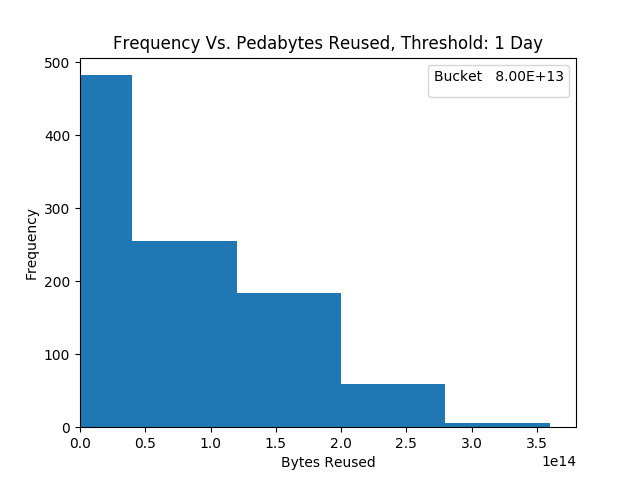

bSize: 17384169763353
bSize: 11417356389871
bSize: 11629273790388
bSize: 9170286265555
bSize: 8696057518603
bSize: 10690094399519
bSize: 12939931327568
bSize: 14177076217685
bSize: 13718489166093
bSize: 21092154248581
bSize: 22245721454353
bSize: 13294313444561
bSize: 9275085343751
bSize: 17249597833414
bSize: 10315430742961
bSize: 25266011554600
bSize: 12079410245799
bSize: 10492573851734
bSize: 7898103445654
bSize: 7152891863880
bSize: 11115508591408
bSize: 17984587120253
bSize: 20857776145037
bSize: 28293056141946
bSize: 27223843101276
bSize: 11619425154430
bSize: 18287167976384
bSize: 9659692314786
bSize: 24089748032108
bSize: 27710729708804
bSize: 22906085772990
bSize: 17262660843336
bSize: 15527746018076
bSize: 15324148995926
bSize: 17399872857808
bSize: 17993522207362
bSize: 26468193134983
bSize: 37501587479298
bSize: 37199542880685
bSize: 29842384081459
bSize: 11682139806045
bSize: 24711248010420
bSize: 26375464149435
bSize: 20338358197833
bSize: 33798726720589
bSize: 415849548

bSize: 61090441066947
bSize: 121950798672418
bSize: 111808149499041
bSize: 121830475607271
bSize: 104595857147408
bSize: 87536278618948
bSize: 92088825464897
bSize: 81573982858920
bSize: 80088889618379
bSize: 88437050742818
bSize: 95795739241241
bSize: 86825587681472
bSize: 164415685202740
bSize: 166021375042099
bSize: 195189934686337
bSize: 212329013076954
bSize: 148153418387972
bSize: 168458971019167
bSize: 110883139059876
bSize: 108880224094843
bSize: 129058400565389
bSize: 122933477959415
bSize: 179531716897469
bSize: 86787727878696
bSize: 180012317505877
bSize: 180549204807551
bSize: 155141800078965
bSize: 116950388850814
bSize: 38128090122541
bSize: 55785464383458
bSize: 64043598895880
bSize: 61216929819290
bSize: 189762784924846
bSize: 107314637684146
bSize: 110125883999378
bSize: 106225314822862
bSize: 82305485710517
bSize: 101652403714443
bSize: 153656616405005
bSize: 112327372065631
bSize: 40350608251805
bSize: 47754980879892
bSize: 157042743178876
bSize: 172292542470804
bSiz

bSize: 154615394046471
bSize: 80167083899308
bSize: 88162463972858
bSize: 62369503543843
bSize: 153163591454849
bSize: 203620990072259
bSize: 202162853536901
bSize: 243797006148917
bSize: 204114300178540
bSize: 193956852842855
bSize: 182217352315869
bSize: 242292383459299
bSize: 238163897842670
bSize: 210226567406855
bSize: 258881709054459
bSize: 120295549377927
bSize: 99457663510112
bSize: 147233500731053
bSize: 187211308927795
bSize: 200459362867798
bSize: 190947589121383
bSize: 260024940090598
bSize: 206539300111912
bSize: 213505626085040
bSize: 195777523188241
bSize: 197471861507583
bSize: 193468184083534
bSize: 215891785156592
bSize: 257620854123432
bSize: 162197322868038
bSize: 183852849653084
bSize: 215861839279373
bSize: 190055477514421
bSize: 256732382761389
bSize: 259891375713852
bSize: 221046502586509
bSize: 160560741609426
bSize: 184168292645263
bSize: 168893988404027
bSize: 253064694490412
bSize: 252987082152289
bSize: 262348096836640
bSize: 274860108001027
bSize: 19812119

No handles with labels found to put in legend.


bSize: 213767012130384
bSize: 217828423310882
bSize: 171169120996752
bSize: 189612570272449
bSize: 116799282060936
bSize: 182684279849909
bSize: 175467567138226


In [35]:
fig, ax = plt.subplots(1,1)
bucket = 8*1e13
block_reuse_dict1 = countByteReuseFreq(1, bucket)
ax.bar(list(block_reuse_dict1.keys()), list(block_reuse_dict1.values()), width=bucket)
ax.set_title('Frequency Vs. Pedabytes Reused, Threshold: 1 Day')
ax.legend(title='Bucket ' + str(format(bucket, "10.2E")))
ax.set_ylabel('Frequency')
ax.set_xlabel('Bytes Reused')
ax.set_ylim(0, None)
ax.set_xlim(0, None)
plt.savefig(resultDirectory + 'ByteReuseThreshold1.png')

<IPython.core.display.Javascript object>


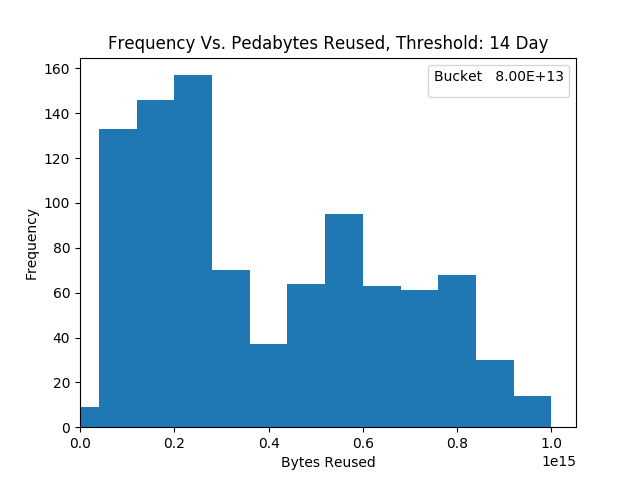

No handles with labels found to put in legend.


In [44]:
fig, ax = plt.subplots(1,1)
bucket = 8*1e13
block_reuse_dict14 = countByteReuseFreq(14, bucket)
ax.bar(list(block_reuse_dict14.keys()), list(block_reuse_dict14.values()), width=bucket)
ax.set_title('Frequency Vs. Pedabytes Reused, Threshold: 14 Day')
ax.legend(title='Bucket ' + str(format(bucket, "10.2E")))
ax.set_ylabel('Frequency')
ax.set_xlabel('Bytes Reused')
ax.set_ylim(0, None)
ax.set_xlim(0, None)
plt.savefig(resultDirectory + 'ByteReuseThreshold14.png')

<IPython.core.display.Javascript object>


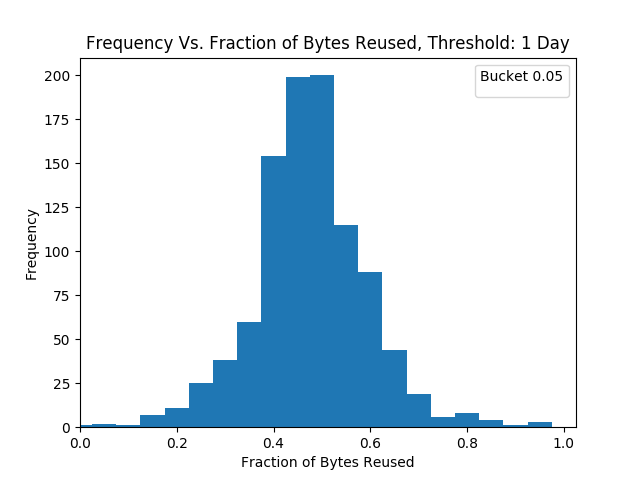

62
572


No handles with labels found to put in legend.


1090


In [37]:
fig, ax = plt.subplots(1,1)
bucket = 0.05
block_reuse_dict1 = countByteFracReuseFreq(1, bucket)
ax.bar(list(block_reuse_dict1.keys()), list(block_reuse_dict1.values()), width=bucket)
ax.set_title('Frequency Vs. Fraction of Bytes Reused, Threshold: 1 Day')
ax.legend(title='Bucket ' + str(bucket))
ax.set_ylabel('Frequency')
ax.set_xlabel('Fraction of Bytes Reused')
ax.set_ylim(0, None)
ax.set_xlim(0, None)
plt.savefig(resultDirectory + 'ByteFracReuseThreshold1.png')

<IPython.core.display.Javascript object>


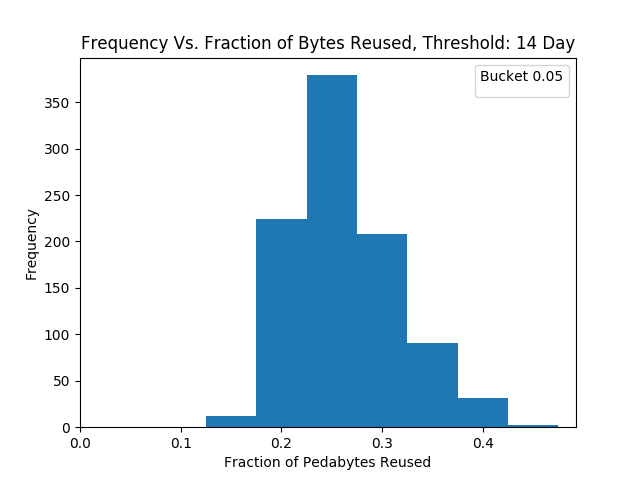

62
62
62
62
62
62
62
62
62
62
62
62
62
62
572
572
572
572
572
572
572
572
572
572
572
572
572
572
1090
1090
1090
1090
1090
1090
1090
1090


No handles with labels found to put in legend.


1090
1090
1090
1090
1090
1090


In [38]:
fig, ax = plt.subplots(1,1)
bucket = 0.05
block_reuse_dict14 = countByteFracReuseFreq(14, bucket)
ax.bar(list(block_reuse_dict14.keys()), list(block_reuse_dict14.values()), width=bucket)
ax.set_title('Frequency Vs. Fraction of Bytes Reused, Threshold: 14 Day')
ax.legend(title='Bucket ' + str(bucket))
ax.set_ylabel('Frequency')
ax.set_xlabel('Fraction of Pedabytes Reused')
ax.set_ylim(0, None)
ax.set_xlim(0, None)
plt.savefig(resultDirectory + 'ByteFracReuseThreshold14.png')

In [39]:
endTime = datetime.datetime.now()
timeDifference = endTime-startTime
print("Total Runtime:")
print(timeDifference)

Total Runtime:
0:48:57.691392


In [21]:
print(ws)

                  day SubmissionTool          input_campaign  d_data_tier_id  \
0        1.453162e+09          crab3                      HC             122   
1        1.453162e+09          crab3   RunIISpring15FSPremix           31224   
2        1.453248e+09          crab3                Run2015B               7   
3        1.453248e+09          crab3                Run2015D               9   
4        1.453334e+09          crab3                Run2015C               9   
5        1.453334e+09          crab3       RunIISpring15DR74              21   
6        1.453421e+09          crab2    RunIIFall15MiniAODv1           31224   
7        1.453421e+09          crab2       RunIISpring15DR74              21   
8        1.453421e+09          crab2  RunIISpring15MiniAODv2           31224   
9        1.453421e+09          crab3    RunIIFall15MiniAODv2           31224   
10       1.453507e+09          crab3                  HCtest             122   
11       1.453507e+09          crab3    

In [22]:
# Finds the number of days total in working_set_day
print("Number of days in working_set_day:")
print(len(list(ws['day'].unique())))
# Finds the number of days covered in the dbs_blocks dataset
print("Number of days covered:")
print(len(date_index))
# Find the dates that are covered
print("Dates that are covered:")
print(str(date_index_ts[0]) 
      + ' to '
      + str(date_index_ts[len(date_index_ts)-1]))
# Finds the number of unique input_campaigns and outputs them
print("Number of unique input_campaigns:")
print(len(list(ws['input_campaign'].unique())))
# Finds the total number of jobs (assuming njobs is the number
# of jobs ran per row)
print("Number jobs total:")
print(ws['njobs'].sum())
# Finds the number of blocks total in the database
print("Total number of blocks in dbs_blocks:")
print(len(blocksize))
# Finds the total number of blocks accessed (in the given working set)
# in the database
accessed_block_set = set()
for block in ws['working_set_blocks']:
    accessed_block_set.update(block)
print("Total number of unique blocks accessed in the working set:")
print(len(accessed_block_set))
# Finds the total data across all blocks
print("Total number of bytes across all blocks:")
print(str(sum(blocksize)[1]/2e15) + " PB")

Number of days in working_set_day:
999
Number of days covered:
1089
Dates that are covered:
2016-01-07 to 2018-12-30
Number of unique input_campaigns:
319
Number jobs total:
604617621
Total number of blocks in dbs_blocks:
8935351
Total number of unique blocks accessed in the working set:
861526
Total number of bytes across all blocks:
180.63418737961337 PB


In [23]:
campaign_list = list(ws['input_campaign'].unique())

# Finds the number of blocks for a given campaign
# Parameters: campaign - String detailing the name of the campaign
#                        to be searched
# Returns the number of blocks for a given campaign
def countCampaignBlocks(campaign):
    campaignBlockQuantity = 0
    campaignIndices = [i for i, 
                       x in enumerate(list(ws['input_campaign']))
                      if x == campaign]
    for i in campaignIndices:
        campaignBlockQuantity += len(ws['working_set_blocks'][i])
    return campaignBlockQuantity

# Finds the total number of bytes used in a given campaign
# Parameters: campaign - String detailing the name of the campaign
#                        to be searched
# Returns the total number of bytes used in a given campaign
def countCampaignBytes(campaign):
    campaignByteQuantity = 0
    campaignIndices = [i for i, 
                       x in enumerate(list(ws['input_campaign']))
                      if x == campaign]
    for i in campaignIndices:
        campaignByteQuantity += sum(ws['working_set_blocks'][i])
    return campaignByteQuantity

# Creating a dictionary of quantity of blocks per campaign
# Keys: Quantity of Blocks
# Values: Quantity of Campaigns that have that Quantity of Blocks
def campaignBlockSumDict(bucket):
    campaignBlockDict = {}
    for campaign in campaign_list:
        try: 
            campaignBlockQuantity = countCampaignBlocks(campaign)
            if (round_down(campaignBlockQuantity, bucket)) in campaignBlockDict:
                campaignBlockDict[round_down(campaignBlockQuantity, bucket)] += 1
            else:
                campaignBlockDict[round_down(campaignBlockQuantity, bucket)] = 1           
        except exception as e:
            emptykey = e
    return campaignBlockDict
            
# Creating a dictionary of bytes per campaign
# Keys: Bytes
# Values: Quantity of Campaigns that have that number of bytes
def campaignByteSumDict(bucket):
    campaignByteDict = {}
    for campaign in campaign_list:
        try: 
            campaignByteQuantity = countCampaignBytes(campaign)
            if (round_down(campaignByteQuantity, bucket)) in campaignByteDict:
                campaignByteDict[round_down(campaignByteQuantity, bucket)] += 1
            else:
                campaignByteDict[round_down(campaignByteQuantity, bucket)] = 1           
        except exception as e:
            emptykey = e
    return campaignByteDict
    

In [24]:
# Defining the directory in which
resultDirectory = 'Results/dbs_blocks/'
if not os.path.exists(resultDirectory):
    os.mkdir(resultDirectory)

<IPython.core.display.Javascript object>


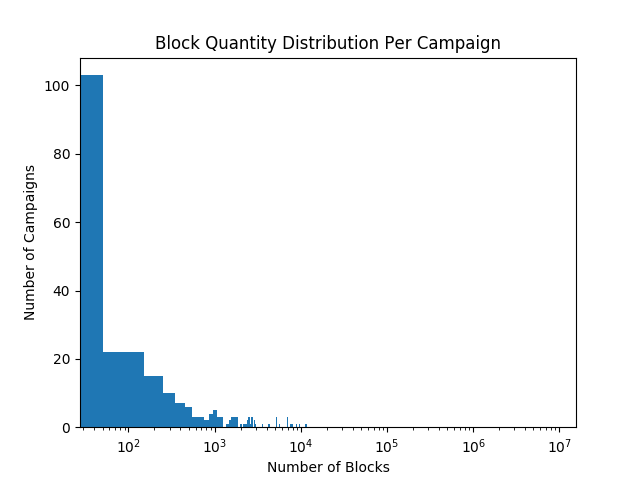

In [25]:
fig, ax = plt.subplots(1,1)
bucket = 100
campaignBlockDict = campaignBlockSumDict(bucket)
ax.bar(list(campaignBlockDict.keys()), list(campaignBlockDict.values()), width=1e2)
ax.set_title('Block Quantity Distribution Per Campaign')
ax.set_xscale('log')
ax.set_xlabel('Number of Blocks')
ax.set_ylabel('Number of Campaigns')
ax.set_ylim(0,None)
plt.savefig(resultDirectory + 'blockQuantityPerCampaign.png')

In [26]:
print(list(campaignBlockDict.values()))
print(list(campaignBlockDict.keys()))

[103, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 3, 2, 5, 1, 1, 1, 1, 1, 1, 1, 1, 6, 22, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 15, 1, 3, 1, 1, 1, 1, 3, 7, 1, 1, 1, 1, 3, 4, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 2]
[0, 19200, 101100, 1800, 600, 1349900, 3600, 74200, 20600, 26900, 36400, 1887000, 26500, 9500, 32800, 17200, 36900, 146400, 28200, 2600, 1500, 300, 4580400, 1230600, 27700, 104800, 44600, 124600, 227900, 48700, 8000, 2400, 44100, 9200, 118100, 21900, 2973400, 11600, 607800, 1100, 2900, 1000, 6200, 954200, 8800, 199100, 1697000, 934000, 125500, 72800, 500, 100, 68200, 634300, 47800, 360300, 8900, 13000, 2156400, 4200, 29300, 5700, 7800, 7700, 19900, 200, 9600, 1600, 13700, 18400, 23600, 475500, 2700, 400, 11800, 2122900, 143700, 2200, 2500, 900, 191200, 106400, 303600, 1700, 9800, 54700, 306400, 7600, 14

<IPython.core.display.Javascript object>


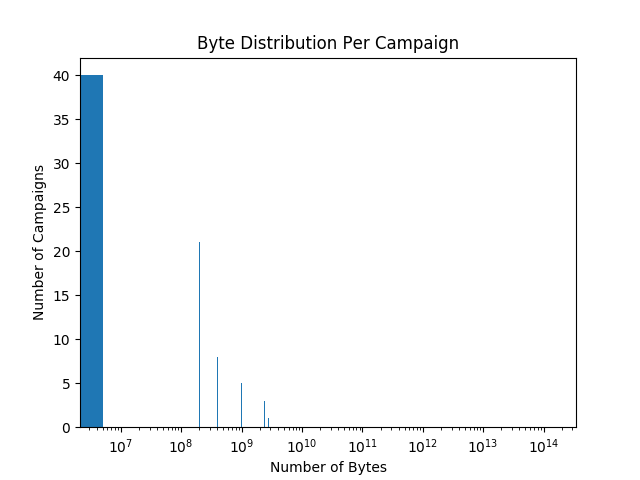

In [27]:
fig, ax = plt.subplots(1,1)
bucket = 2e8
campaignByteDict = campaignByteSumDict(bucket)
ax.bar(campaignByteDict.keys(), campaignByteDict.values(), width=1e7)
ax.set_title('Byte Distribution Per Campaign')
ax.set_xscale('log')
ax.set_xlabel('Number of Bytes')
ax.set_ylabel('Number of Campaigns')
ax.set_ylim(0,None)
plt.savefig(resultDirectory + 'bytesPerCampaign.png')

<IPython.core.display.Javascript object>


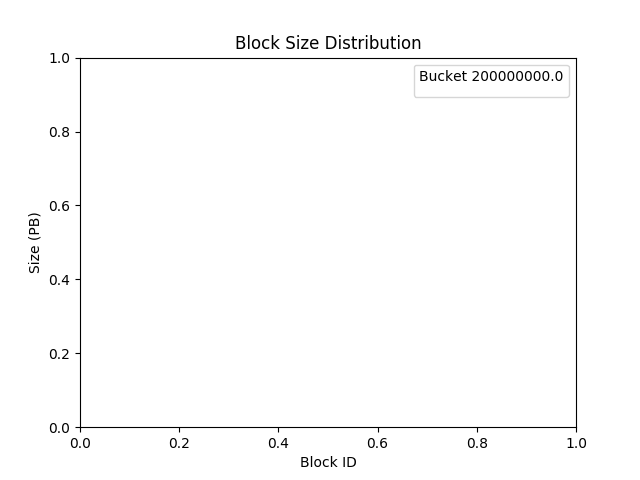

No handles with labels found to put in legend.


In [28]:
# Transposing the blocksize np array to be plotted
blocksizeT = np.transpose(blocksize)

fig, ax = plt.subplots(1,1)
#ax.bar(blocksizeT[0], blocksizeT[1], width=10)
#ax.bar(blocksizeT[0], blocksizeT[1])
ax.set_title('Block Size Distribution')
ax.legend(title='Bucket ' + str(bucket))
ax.set_ylabel('Size (PB)')
ax.set_xlabel('Block ID')
ax.set_ylim(0, None)
ax.set_xlim(0, None)
plt.savefig(resultDirectory + 'blockSizeDistribution.png')